In [3]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from copy import deepcopy

In [2]:
df = pd.read_csv('TSLA-2.csv') 
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
3112,2022-11-07,208.649994,208.899994,196.660004,197.080002,197.080002,93916500
3113,2022-11-08,194.020004,195.199997,186.750000,191.300003,191.300003,128803400
3114,2022-11-09,190.779999,195.889999,177.119995,177.589996,177.589996,127062700
3115,2022-11-10,189.899994,191.000000,180.029999,190.720001,190.720001,132703000
3116,2022-11-11,186.000000,196.520004,182.589996,195.970001,195.970001,114229200


In [200]:
df.shape

(3117, 7)

In [201]:
palette = ['#66CDAE', '#8F3751', '#3E757F', '#D2345B', '#EF794A']

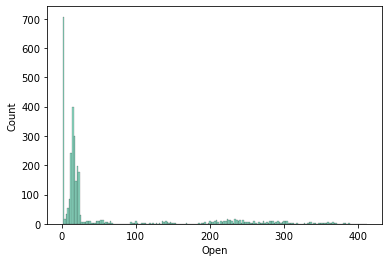

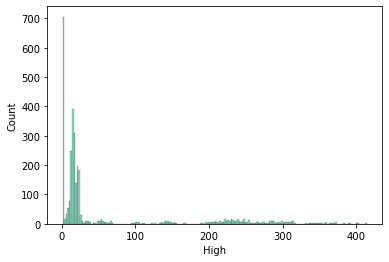

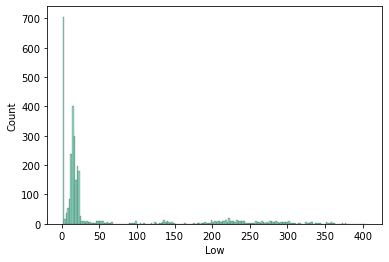

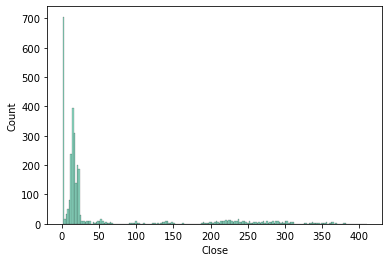

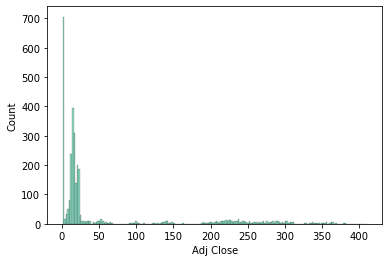

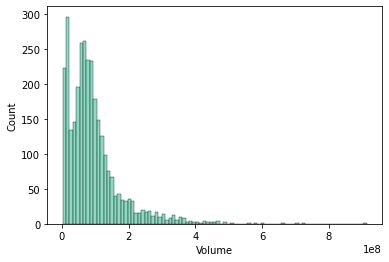

In [202]:
for i in df.columns: #showing the histogram of each column 
  if df[i].dtype != 'object':
    sns.histplot(df, x=i, color=palette[0])
    plt.show()

In [203]:
df.isnull().sum() #no need to use dropna(), no empty data to drop

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [204]:
df = df[['Date', 'Close']] #just pick the date and the closing price to analyze 
df

,Date,Close
0,2010-06-29,1.592667
1,2010-06-30,1.588667
2,2010-07-01,1.464000
3,2010-07-02,1.280000
4,2010-07-06,1.074000
...,...,...
3112,2022-11-07,197.080002
3113,2022-11-08,191.300003
3114,2022-11-09,177.589996
3115,2022-11-10,190.720001


In [205]:
df['Date']

0       2010-06-29
1       2010-06-30
2       2010-07-01
3       2010-07-02
4       2010-07-06
           ...    
3112    2022-11-07
3113    2022-11-08
3114    2022-11-09
3115    2022-11-10
3116    2022-11-11
Name: Date, Length: 3117, dtype: object

In [206]:
def datetime_separate(s): # function the split the year, month, and day
  split = s.split('-') #separate the '-'
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_convert = datetime_separate('2022-10-31')
datetime_convert

datetime.datetime(2022, 10, 31, 0, 0)

In [207]:
df.head()

,Date,Close
0,2010-06-29,1.592667
1,2010-06-30,1.588667
2,2010-07-01,1.464000
3,2010-07-02,1.280000
4,2010-07-06,1.074000


In [208]:
df['Date'] = df['Date'].apply(datetime_separate)
df['Date']

0      2010-06-29
1      2010-06-30
2      2010-07-01
3      2010-07-02
4      2010-07-06
          ...    
3112   2022-11-07
3113   2022-11-08
3114   2022-11-09
3115   2022-11-10
3116   2022-11-11
Name: Date, Length: 3117, dtype: datetime64[ns]

In [209]:
df.index = df.pop('Date') # to replace the index column to date
df

,Close
Date,
2010-06-29,1.592667
2010-06-30,1.588667
2010-07-01,1.464000
2010-07-02,1.280000
2010-07-06,1.074000
...,...
2022-11-07,197.080002
2022-11-08,191.300003
2022-11-09,177.589996


'\nAs we can see, from 2010 Tesla price very steady up. However, after the covid 19, 2020 to today 2022\nthe price is up and down, very volatile\n'

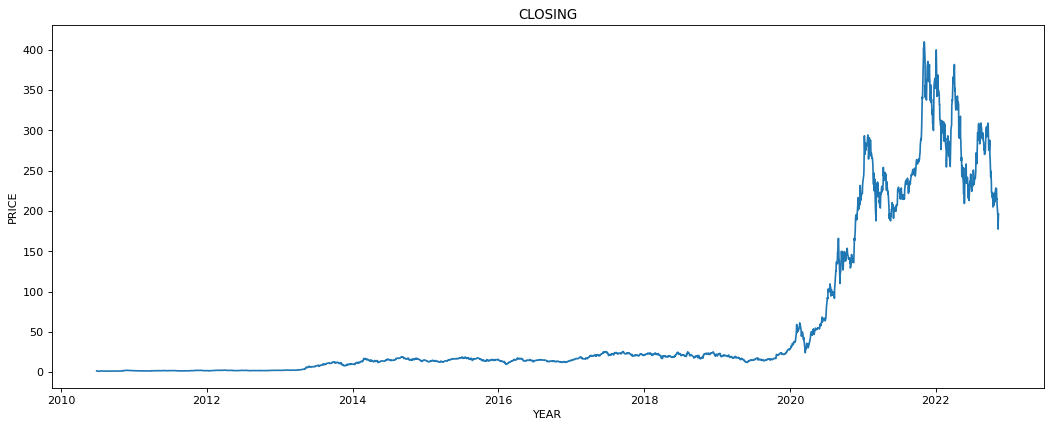

In [210]:
plt.figure(figsize=(16, 6), dpi=80)
plt.plot(df.index, df['Close'])
plt.title("CLOSING", size = '12')
plt.ylabel("PRICE")
plt.xlabel("YEAR")
'''
As we can see, from 2010 Tesla price very steady up. However, after the covid 19, 2020 to today 2022
the price is up and down, very volatile
'''

In [211]:
'''
The function to convert into supervised learning problem
take the datafame which passed df. Will take first date of string, and last date of string 
then take positive integer will set defaut by 3.
the input is 3 days, 2 days, and 1 day before the target day. 
'''
def df_convertion(dataframe, first_date_str, last_date_str, n=3):
  first_date = datetime_separate(first_date_str)
  last_date  = datetime_separate(last_date_str)
  target_date = first_date  
  dates = []
  X, Y = [], []
  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)   
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return
    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]
    dates.append(target_date)
    X.append(x)
    Y.append(y)
    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))   
    if last_time:
      break   
    target_date = next_date
    if target_date == last_date:
      last_time = True   
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates 
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]  
  ret_df['Target'] = Y
  return ret_df
windowed_df = df_convertion(df,'2021-11-01', '2022-11-01', n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-11-01,345.953339,359.013336,371.333344,402.863342
1,2021-11-02,359.013336,371.333344,402.863342,390.666656
2,2021-11-03,371.333344,402.863342,390.666656,404.619995
3,2021-11-04,402.863342,390.666656,404.619995,409.970001
4,2021-11-05,390.666656,404.619995,409.970001,407.363342
...,...,...,...,...,...
248,2022-10-26,214.440002,211.250000,222.419998,224.639999
249,2022-10-27,211.250000,222.419998,224.639999,225.089996
250,2022-10-28,222.419998,224.639999,225.089996,228.520004
251,2022-10-31,224.639999,225.089996,228.520004,227.539993


In [212]:
'''
A function to convert to date x and y, three dimensional
Y is going to be the output of the vector
-to see how the variable change over time. 
'''
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()
  dates = df_as_np[:, 0]
  middle_matrix = df_as_np[:, 1:-1] # just the 3 middle columns (t-3,t-2,t-1)
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1)) #1st dimension is the len of dates
  Y = df_as_np[:, -1] # the y output, we want all the row, last column
  return dates, X.astype(np.float32), Y.astype(np.float32) #using astype(np.float32) incase errors
dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((253,), (253, 3, 1), (253,))

Text(0.5, 0, 'YEAR')

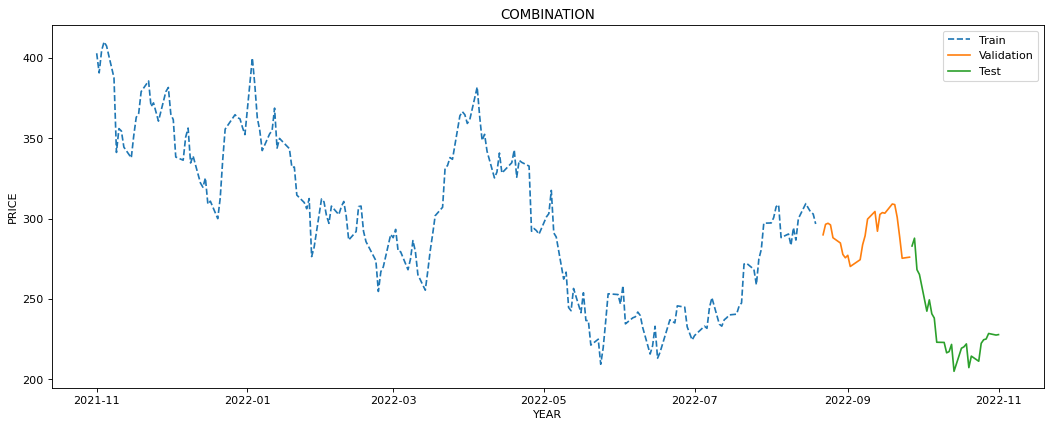

In [213]:
'''
ML, split the data into train, validation, and test 
-the train will be trained the model
-the validation will help training data
-the test is used to evaluate the performance of the model

'''
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80] # train the first 80%

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90] # from 80% to 90%
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:] # the testing is from 90%, which is the last 10%

plt.figure(figsize=(16, 6), dpi=80)
plt.plot(dates_train, y_train, linestyle = 'dashed')
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])
plt.title("COMBINATION", size = '12')
plt.ylabel("PRICE")
plt.xlabel("YEAR")

In [214]:
'''
to Create and train the model using tensorflow

-using lstm neural network
-LSTM networks (Long Short-Term Memory) are predominately used to learn, process, and classify sequential data because these networks can learn long-term dependencies 
between time steps of data. Common LSTM applications include sentiment analysis, language modeling, speech recognition, and video analysis.
-input 3,1 -> 3 days from the past and 1 feature
-chosing 64 for tsla, number of neurons, and the activation is relu
-complile the function using mse (mean squared error), sepecify the optimizer equal to the adam optimizer where we specify that learning rate
- fit the data, and 100 runs through the data set 

'''
model = Sequential([layers.Input((3, 1)), layers.LSTM(64), layers.Dense(32, activation='relu'), layers.Dense(32, activation='relu'), layers.Dense(1)])
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 2s 79ms/step - loss: 93991.2578 - mean_absolute_error: 302.6045 - val_loss: 84584.8672 - val_mean_absolute_error: 290.5991
Epoch 2/100
7/7 [==============================] - 0s 11ms/step - loss: 93662.5078 - mean_absolute_error: 302.0614 - val_loss: 84324.2812 - val_mean_absolute_error: 290.1505
Epoch 3/100
7/7 [==============================] - 0s 20ms/step - loss: 93438.5234 - mean_absolute_error: 301.6903 - val_loss: 84150.7109 - val_mean_absolute_error: 289.8512
Epoch 4/100
7/7 [==============================] - 0s 14ms/step - loss: 93251.2109 - mean_absolute_error: 301.3773 - val_loss: 83942.1797 - val_mean_absolute_error: 289.4912
Epoch 5/100
7/7 [==============================] - 0s 15ms/step - loss: 93015.5781 - mean_absolute_error: 300.9898 - val_loss: 83696.7812 - val_mean_absolute_error: 289.0671
Epoch 6/100
7/7 [==============================] - 0s 10ms/step - loss: 92724.1719 - mean_absolute_error: 300.5037 - val_loss: 833

7/7 [==============================] - 0s 7ms/step - loss: 203.5160 - mean_absolute_error: 11.0070 - val_loss: 107.4254 - val_mean_absolute_error: 8.2242
Epoch 98/100
7/7 [==============================] - 0s 8ms/step - loss: 206.9355 - mean_absolute_error: 11.2456 - val_loss: 121.3603 - val_mean_absolute_error: 8.8591
Epoch 99/100
7/7 [==============================] - 0s 7ms/step - loss: 228.9764 - mean_absolute_error: 11.5408 - val_loss: 60.0801 - val_mean_absolute_error: 6.3901
Epoch 100/100
7/7 [==============================] - 0s 7ms/step - loss: 203.4075 - mean_absolute_error: 10.8983 - val_loss: 57.0682 - val_mean_absolute_error: 6.3777


7/7 [==============================] - 0s 2ms/step


Text(0.5, 0, 'YEAR')

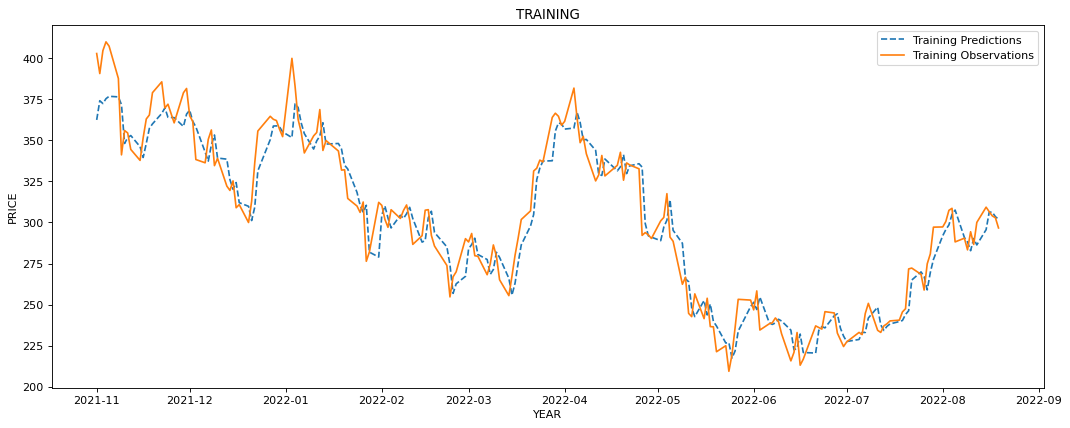

In [215]:
train_predictions = model.predict(X_train).flatten()

plt.figure(figsize=(16, 6), dpi=80)
plt.plot(dates_train, train_predictions, linestyle = 'dashed')
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])
plt.title("TRAINING", size = '12')
plt.ylabel("PRICE")
plt.xlabel("YEAR")

1/1 [==============================] - 0s 20ms/step


Text(0.5, 0, 'YEAR')

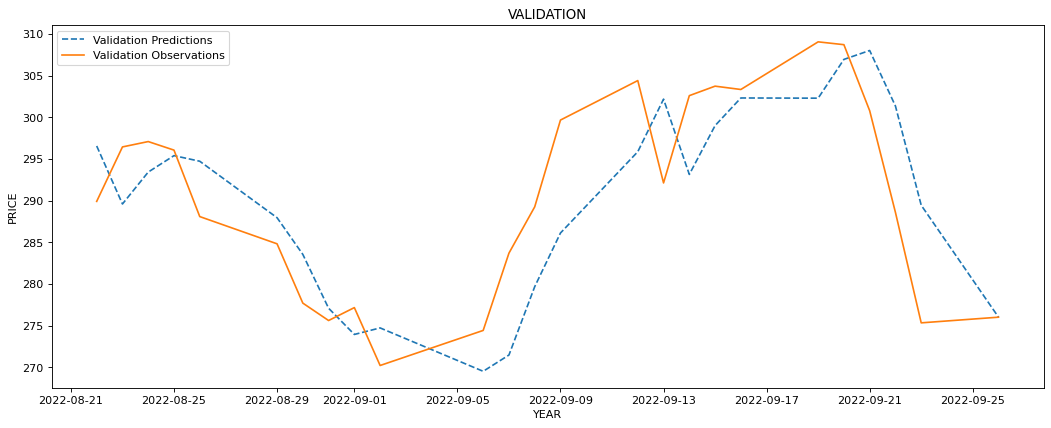

In [216]:
val_predictions = model.predict(X_val).flatten()

plt.figure(figsize=(16, 6), dpi=80)
plt.plot(dates_val, val_predictions, linestyle = 'dashed')
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])
plt.title("VALIDATION", size = '12')
plt.ylabel("PRICE")
plt.xlabel("YEAR")

1/1 [==============================] - 0s 18ms/step


Text(0.5, 0, 'YEAR')

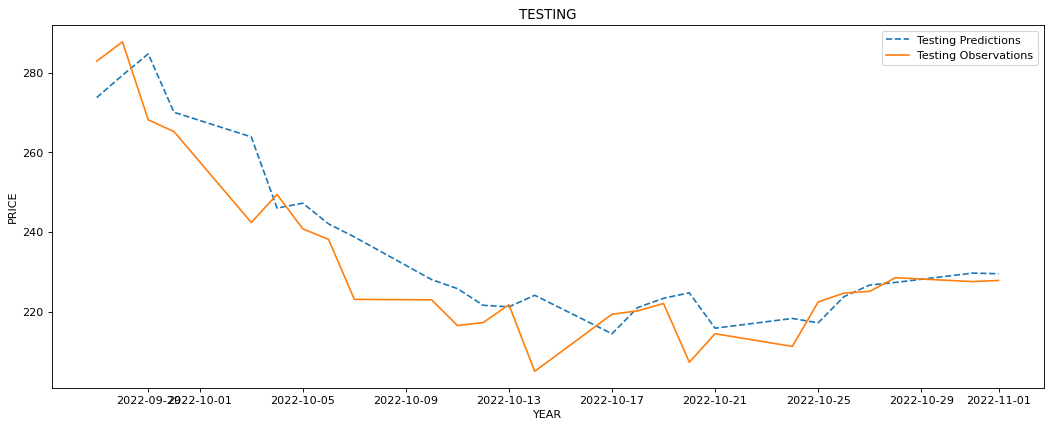

In [217]:
test_predictions = model.predict(X_test).flatten()

plt.figure(figsize=(16, 6), dpi=80)
plt.plot(dates_test, test_predictions, linestyle = 'dashed')
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])
plt.title("TESTING", size = '12')
plt.ylabel("PRICE")
plt.xlabel("YEAR")

Text(0.5, 0, 'YEAR')

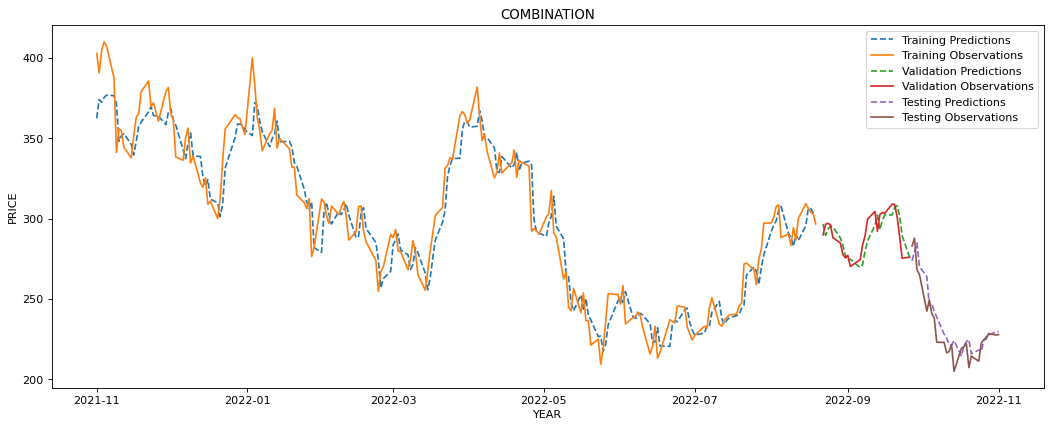

In [218]:
'''
The lines are extremely closed to each other
'''
plt.figure(figsize=(16, 6), dpi=80)
plt.plot(dates_train, train_predictions, linestyle = 'dashed')
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions, linestyle = 'dashed')
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions, linestyle = 'dashed')
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 'Training Observations', 'Validation Predictions', 'Validation Observations', 'Testing Predictions', 'Testing Observations'])
plt.title("COMBINATION", size = '12')
plt.ylabel("PRICE")
plt.xlabel("YEAR")

In [219]:
'''
From this part, we are going to predict the future using recursive, copy the previous data using deepcopy
we start with dates_val, and dates_test, based on the validation and the testing plot above

'''

future_price_predictions = []
future_price_dates = np.concatenate([dates_val, dates_test])

for target_date in future_price_dates:
  last_window = deepcopy(X_train[-1]) # from the validation to x_train
  next_prediction = model.predict(np.array([last_window])).flatten() #prediting future price base on the train
  future_price_predictions.append(next_prediction) #append to the future data
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 18ms/step


Text(0.5, 0, 'YEAR')

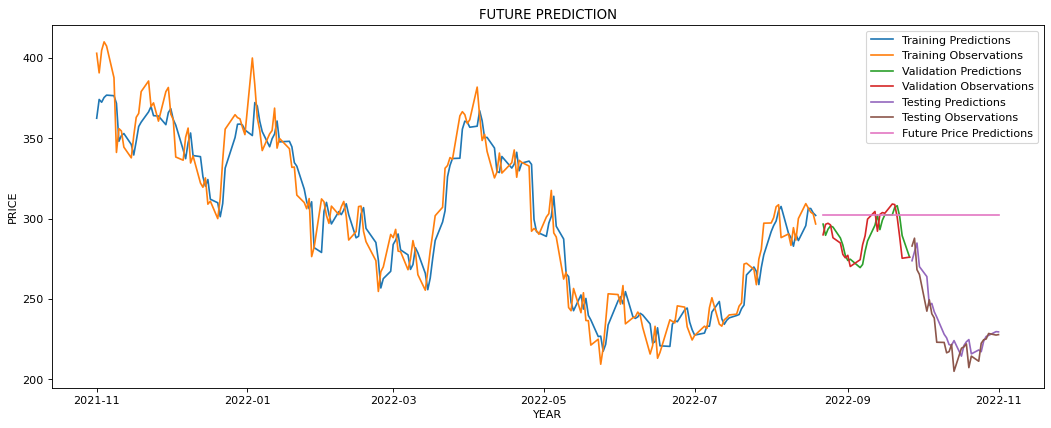

In [220]:
'''
The model has no idea how to predict the stock price for the future. It just think it will be like what it is before
and actually, it is reasonal prediction. predicting stock price is extremely difficult 
'''

plt.figure(figsize=(16, 6), dpi=80)
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(future_price_dates, future_price_predictions)
plt.legend(['Training Predictions', 'Training Observations', 'Validation Predictions', 'Validation Observations', 'Testing Predictions', 'Testing Observations', 'Future Price Predictions'])
plt.title("FUTURE PREDICTION", size = '12')
plt.ylabel("PRICE")
plt.xlabel("YEAR")